<a href="https://colab.research.google.com/github/dorlavy1/Coursera_Capstone/blob/master/Capstone_Project_The_Battle_of_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - Battle of Neighborhoods

# Introduction/Business Problem 
A description of the problem and a discussion of the background

This project is addressed to people who wants to open a restaurant.

If you want to open a restaurant in London it's not enough just to know how to cook. One of the first questions that pops into your mind is "Where would i open it?"

This question is depend on various variables, such as:
1. what food are you cooking? 
2. is it an evening restaurant or maybe you aim it for lunch time?
3. will it be an expensive restaurant/fast food/ ethnic food ?
etc...

In order to succeed you have to succesfuly address these questions before looking for a place.
We are aiming our project for fast food restaurant that aims for lunch time/early afternoon hours.

   ## The problem: Where should I open my burger restaurant in London?

# Data understanding:
A description of the data and how it will be used to solve the problem

1. We will use web scraping from Wikipedia in order to get all the neighborhoods in London. we will use the following columns from the table: Location,London borough,Post town, Postcode district. Dial code and OS grid ref will be remove during data cleaning since this information has no added value for our goal. The Wikipedia page can be found in : https://en.wikipedia.org/wiki/List_of_areas_of_London
2. Will add the Latitude and Longitude for each neighborhood using CSV dataset from doogal.
3. Visualize london map including the neighborhood dataframe we described using folium (same as we did for New York & Toronto)
4. Since we want to open our restaurant during lunch time we need to aim for neighborhoods with many schools/workplaces. People are staying there during the day and look for quick lunch place. In order to do so we will use Foursquare API to get the number of workplaces and schools in every neighborhood and summarize it in order to compare between neighborhoods.
5. Will recommend the best neighborhood based on the data above



In [1]:
#Importing the libraries we will use during this project - pandas, numpy, json, geocoders, requests, matplotlib, KMeans & folium

import pandas as pd
import numpy as np # library to handle data in a vectorized manner

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

In [2]:
#Will use pandas web scraping to import London neighborhoods information from Wikipedia to pandas dataframe

url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
df_list = pd.read_html(url)
print('number of lists is ', len(df_list)) #number of lists created from the Wikipedia page
df = pd.DataFrame(df_list[1]) #creating dataframe from the list of interest
df.shape

number of lists is  5


(532, 6)

In [3]:
#Let's examine our dataframe
print(df.columns.tolist())

df.head()

['Location', 'London\xa0borough', 'Post town', 'Postcode\xa0district', 'Dial\xa0code', 'OS grid ref']


,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


## Data cleaning 
1. You can see above we have issues in the 2nnd, 4th & 5th columns since they are including '\xa0' instead of space. Therefore we will fix the column name
2. Remove "Dial code" & "OS grid ref" columns since we don't need them for our project. Borough & Postcode district information will be sufficient. \
3. As you can see in the top 4 rows, there is "[x]" sign. This is due to Wikipedia reference note. We don't need it, therefore will remove it.\
4. check for "Not assigned" / empty cells.
5. Will use only 'Post_town' = London for our search

In [4]:
#Fixing columns names
df.columns = [c.replace(' ', '_') for c in df.columns]
df.columns = [c.replace('\xa0', '_') for c in df.columns]
print(df.columns.tolist())

df['London_borough'] = df['London_borough'].map(lambda x: x.rstrip('[]1234567890'))                       

['Location', 'London_borough', 'Post_town', 'Postcode_district', 'Dial_code', 'OS_grid_ref']


In [5]:
#Remove [x] for 'London_borough' column
df['London_borough'].unique()

array(['Bexley, Greenwich ', 'Ealing, Hammersmith and Fulham', 'Croydon',
       'Bexley', 'Redbridge', 'City', 'Westminster', 'Brent', 'Bromley',
       'Islington', 'Havering', 'Barnet', 'Enfield', 'Wandsworth',
       'Southwark', 'Barking and Dagenham', 'Richmond upon Thames',
       'Newham', 'Sutton', 'Ealing', 'Lewisham', 'Harrow', 'Camden',
       'Kingston upon Thames', 'Tower Hamlets', 'Greenwich', 'Haringey',
       'Hounslow', 'Lambeth',
       'Kensington and ChelseaHammersmith and Fulham', 'Waltham Forest',
       'Redbridge, Barking and Dagenham', 'Kensington and Chelsea',
       'Hounslow, Ealing, Hammersmith and Fulham', 'Lambeth, Wandsworth',
       'Barnet, Enfield', 'Merton', 'Hillingdon', 'Barnet, Brent, Camden',
       'Hackney', 'Bexley, Greenwich', 'Islington & City',
       'Haringey, Islington', 'Hammersmith and Fulham',
       'Greenwich, Lewisham', 'Lambeth, Southwark', 'Brent, Harrow',
       'Brent, Camden', 'Camden and Islington', 'Haringey and Barnet',
 

In [6]:
#Remove "Dial code" & "OS grid ref" columns
df.drop(columns=['Dial_code', 'OS_grid_ref'],inplace=True)

In [7]:
#Check for NaN/empty cells
np.where(pd.isnull(df)) # Both row array and column array are empty therefore there are no NaN values or empty cells in the dataframe

(array([], dtype=int64), array([], dtype=int64))

In [8]:
#Will use only 'Post_town' = London for our search. Therefore we will remove all other rows.
df=df[df['Post_town'].str.contains("LONDON")]

In [9]:
#We reduced the number of rows from 533 to 310.
df.shape

(309, 4)

In [10]:
df.head()


,Location,London_borough,Post_town,Postcode_district
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4"
6,Aldgate,City,LONDON,EC3
7,Aldwych,Westminster,LONDON,WC2
9,Anerley,Bromley,LONDON,SE20


In [11]:
#You can see above that in some Postcode_district we have multiple values. Therefore we must split it, since each Postcode_district refer to a different map coordinates.
#Will use chain library from itertools for splitting and duplicate the rows.

from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = df['Postcode_district'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
res = pd.DataFrame({'Location': np.repeat(df['Location'], lens),
                    'Post_town': np.repeat(df['Post_town'], lens),
                    'London_borough': np.repeat(df['London_borough'], lens),
                    'Postcode_district': chainer(df['Postcode_district'])})
df=res
df.rename(columns={'Postcode_district': 'Postcode'}, inplace=True)
df['Postcode'] = df['Postcode'].str.lstrip() #removing spaces after splitting

In [12]:
df.head()

,Location,Post_town,London_borough,Postcode
0,Abbey Wood,LONDON,"Bexley, Greenwich",SE2
1,Acton,LONDON,"Ealing, Hammersmith and Fulham",W3
1,Acton,LONDON,"Ealing, Hammersmith and Fulham",W4
6,Aldgate,LONDON,City,EC3
7,Aldwych,LONDON,Westminster,WC2


In [13]:
#removing duplicates Postcodes will reduce the number of rows from 382 to 176
df.drop_duplicates(subset ="Postcode", keep = 'first' , inplace = True)
df.shape

(132, 4)

## Adding Latitude and Longitude for each neighborhood using doogal dataset https://www.doogal.co.uk/london_postcodes.php

In [14]:
#Check how many postcode_district we have
df['Postcode'].unique()

array(['SE2', 'W3', 'W4', 'EC3', 'WC2', 'SE20', 'EC1', 'N1', 'N19', 'EN5',
       'NW7', 'N11', 'N14', 'SW12', 'SE1', 'EC2', 'SW13', 'SW11', 'W2',
       'BR3', 'E6', 'E16', 'IG11', 'SW1', 'SE6', 'NW3', 'E2', 'DA6',
       'DA7', 'EC4', 'SE3', 'SE12', 'E14', 'WC1', 'N22', 'E3', 'NW2',
       'NW4', 'NW10', 'SW2', 'SW9', 'SE5', 'SE4', 'SW3', 'NW6', 'NW1',
       'E11', 'SE7', 'W1', 'E4', 'N3', 'SW4', 'NW9', 'SW19', 'N10', 'N8',
       'SE19', 'SE26', 'E8', 'SE8', 'SE21', 'W5', 'W13', 'SW5', 'SW10',
       'SW18', 'SE22', 'N2', 'SW14', 'N9', 'N18', 'SE11', 'SE17', 'SE9',
       'DA16', 'N12', 'N4', 'E7', 'SE23', 'SW6', 'SE27', 'NW11', 'NW5',
       'N21', 'SE10', 'E5', 'E9', 'N16', 'W6', 'W7', 'N15', 'SE24', 'N5',
       'N6', 'SE13', 'W8', 'W11', 'W14', 'N7', 'SW7', 'HA3', 'SW15',
       'E10', 'E15', 'NW8', 'E12', 'W9', 'DA14', 'DA15', 'E1', 'SE14',
       'SW8', 'SW16', 'W10', 'SE15', 'N20', 'N13', 'E13', 'SE18', 'HA7',
       'HA8', 'SW20', 'SE16', 'SE25', 'W12', 'E18', 'N17', 'SE28'

In [15]:
#The CSV file contains much more specific information than we need. therefore we will remove the sub neighborhoods codes and will keep only the neighborhoods Long/Lat (i.e. AB1 XXX -> AB1)
#Will use only the following columns: Latitude, Longitude & Postal code

In [31]:
from google.colab import files
import io
col_list = ["Longitude", "Latitude" , "Postcode"]
London_postcodes = pd.read_csv('London_postcodes.csv', usecols=col_list)
London_postcodes.head()

,Postcode,Latitude,Longitude
0,BR1 1AA,51.401546,0.015415
1,BR1 1AB,51.406333,0.015208
2,BR1 1AD,51.400057,0.016715
3,BR1 1AE,51.404543,0.014195
4,BR1 1AF,51.401392,0.014948


In [35]:
London_postcodes.shape

(329, 3)

In [36]:
#We will remove the sub neighborhoods codes and will keep only the neighborhoods Long/Lat (i.e. AB1 XXX -> AB1)

London_postcodes['Postcode'] = London_postcodes['Postcode'].str.split(" ", n = 1, expand = True)
London_postcodes.drop_duplicates(subset ="Postcode", keep = 'first' , inplace = True)
London_postcodes.shape

(329, 3)

In [37]:
London_postcodes = London_postcodes.reset_index(drop=True)
London_postcodes.head()

,Postcode,Latitude,Longitude
0,BR1,51.401546,0.015415
1,BR2,51.407775,-0.003321
2,BR3,51.407682,-0.032385
3,BR4,51.380973,-0.011615
4,BR5,51.386370,0.064750


In [38]:
#removing duplicate Postcodes [since we are looking on a neighborhood it won't change a lot which Latitude/Longitude we will keep]

#Now we will merge the 2 dataframes by the Postcode

dfinal = df.merge(London_postcodes, on="Postcode", how = 'inner')
dfinal.head()

,Location,Post_town,London_borough,Postcode,Latitude,Longitude
0,Abbey Wood,LONDON,"Bexley, Greenwich",SE2,51.481603,0.122712
1,Acton,LONDON,"Ealing, Hammersmith and Fulham",W3,51.519838,-0.268414
2,Acton,LONDON,"Ealing, Hammersmith and Fulham",W4,51.501346,-0.254217
3,Anerley,LONDON,Bromley,SE20,51.409107,-0.059069
4,Angel,LONDON,Islington,N1,51.539442,-0.117873


In [39]:
dfinal.shape
London_postcodes['Postcode'].unique()

array(['BR1', 'BR2', 'BR3', 'BR4', 'BR5', 'BR6', 'BR7', 'BR8', 'CM13',
       'CM14', 'CM23', 'CR0', 'CR2', 'CR3', 'CR4', 'CR44', 'CR5', 'CR6',
       'CR7', 'CR8', 'CR9', 'CR90', 'DA1', 'DA14', 'DA15', 'DA16', 'DA17',
       'DA18', 'DA5', 'DA6', 'DA7', 'DA8', 'E1', 'E10', 'E11', 'E12',
       'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E1W', 'E2', 'E20', 'E3',
       'E4', 'E5', 'E6', 'E7', 'E77', 'E8', 'E9', 'E98', 'EC1A', 'EC1M',
       'EC1N', 'EC1P', 'EC1R', 'EC1V', 'EC1Y', 'EC2A', 'EC2M', 'EC2N',
       'EC2P', 'EC2R', 'EC2V', 'EC2Y', 'EC3A', 'EC3B', 'EC3M', 'EC3N',
       'EC3P', 'EC3R', 'EC3V', 'EC4A', 'EC4M', 'EC4N', 'EC4P', 'EC4R',
       'EC4V', 'EC4Y', 'EC50', 'EC88', 'EN1', 'EN2', 'EN3', 'EN4', 'EN5',
       'EN6', 'EN7', 'EN8', 'EN9', 'HA0', 'HA1', 'HA2', 'HA3', 'HA4',
       'HA5', 'HA6', 'HA7', 'HA8', 'HA9', 'IG1', 'IG11', 'IG2', 'IG3',
       'IG4', 'IG5', 'IG6', 'IG7', 'IG8', 'IG9', 'KT1', 'KT17', 'KT18',
       'KT19', 'KT2', 'KT22', 'KT3', 'KT4', 'KT5', 'KT6', 'KT7'

In [40]:
#Add map of London using geocoders
address = 'london'

geolocator = Nominatim(user_agent="London_restaurant")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

In [41]:
# add markers to map
for Latitude, Longitude, London_borough, Postcode in zip(dfinal['Latitude'], dfinal['Longitude'], dfinal['London_borough'], dfinal['Postcode']):
    label = '{}, {}'.format(Postcode, London_borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [42]:
#Connecting to Foursquare API:

CLIENT_ID = '240JGPTBQNICEJ4I1JYFOXSF4GKITLWOUFIG1LO0QSJR0K0C' # your Foursquare ID
CLIENT_SECRET = 'VD0M2NNZRN5B1YKNNDC5X5APLKTI3ZM5AYD2G1LR4513MUFM' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 60
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 240JGPTBQNICEJ4I1JYFOXSF4GKITLWOUFIG1LO0QSJR0K0C
CLIENT_SECRET:VD0M2NNZRN5B1YKNNDC5X5APLKTI3ZM5AYD2G1LR4513MUFM


In [43]:
#Let's try to get a list of 30 venues (max) within a radius of 500m

neighbourhood_latitude = dfinal.loc[1, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = dfinal.loc[1, 'Longitude'] # neighborhood longitude value

neighbourhood_name = dfinal.loc[1, 'Postcode'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of W3 are 51.519838, -0.268414.


In [44]:
LIMIT = 70 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
#/v2/venues/search?categoryId=4bf58dd8d48988d121941735,4bf58dd8d48988d11f941735,4bf58dd8d48988d1d8941735,4bf58dd8d48988d1e9931735,4bf58dd8d48988d1e7931735&ll=47.6097,-122.3331&radius=10000&intent=browse&v=20120801

 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&categoryId=4bf58dd8d48988d121941735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fa903b48d464035d6cb4806'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-59d2d423b2958f3e8cd0a252-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/hookahbar_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d119941735',
         'name': 'Hookah Bar',
         'pluralName': 'Hookah Bars',
         'primary': True,
         'shortName': 'Hookah Bar'}],
       'id': '59d2d423b2958f3e8cd0a252',
       'location': {'address': '823 Western Rd',
        'cc': 'GB',
        'city': 'London',
        'country': 'United Kingdom',
        'distance': 955,
        'formattedAddress': ['823 Western Rd',
         'Stonebridge',
         'Greater London',
         'NW10 7LT',
         'United Kingdom'],
        'labeledLatLng

In [45]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [46]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Bamboo Lounge,Hookah Bar,51.528255,-0.271092


In [47]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))


1 venues were returned by Foursquare.


In [48]:
# Create a function that gets the top 100 venues in each Neighborhood within a radius of 1000 meters.

def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&categoryId=4bf58dd8d48988d121941735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode',
                  'London_borough_Latitude', 
                  'London_borough_Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [49]:
nearby_venues.shape

(1, 4)

In [50]:
#create a dataframe for toronto venues

# (dfinal['Latitude'], dfinal['Longitude'], dfinal['London_borough'], dfinal['Postcode']):

london_venues = getNearbyVenues(names=dfinal['Postcode'],
                                   latitudes=dfinal['Latitude'],
                                   longitudes=dfinal['Longitude']
                                  )

SE2
W3
W4
SE20
N1
N19
EN5
NW7
N11
N14
SW12
SE1
SW13
SW11
W2
BR3
E6
E16
IG11
SE6
NW3
E2
DA6
DA7
SE3
SE12
E14
N22
E3
NW2
NW4
NW10
SW2
SW9
SE5
SE4
SW3
NW6
NW1
E11
SE7
W1
E4
N3
SW4
NW9
SW19
N10
N8
SE19
SE26
E8
SE8
SE21
W5
W13
SW5
SW10
SW18
SE22
N2
SW14
N9
N18
SE11
SE17
SE9
DA16
N12
N4
E7
SE23
SW6
SE27
NW11
NW5
N21
SE10
E5
E9
N16
W6
W7
N15
SE24
N5
N6
SE13
W8
W11
W14
N7
SW7
HA3
SW15
E10
E15
NW8
E12
W9
DA14
DA15
E1
SE14
SW8
SW16
W10
SE15
N20
N13
E13
SE18
HA7
HA8
SW20
SE16
SE25
W12
E18
N17
SE28
DA18
SW17
E17
IG8


In [51]:
#list of all the venues within 1000m radius from the neighborhood center (limited to 70 venues per place)

print(london_venues.shape)
london_venues.head()

(264, 7)


,Postcode,London_borough_Latitude,London_borough_Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,W3,51.519838,-0.268414,Bamboo Lounge,51.528255,-0.271092,Hookah Bar
1,W4,51.501346,-0.254217,High Road House,51.492901,-0.254711,Lounge
2,N1,51.539442,-0.117873,The Lexington,51.531669,-0.111359,Rock Club
3,N1,51.539442,-0.117873,Simmons Bar,51.531897,-0.120764,Cocktail Bar
4,N1,51.539442,-0.117873,The Parcel Yard,51.532374,-0.123933,Pub


In [52]:
#Let's group by Postcode to see how many venues we have for each Postcode.
london_venues.groupby('Postcode').count()

,London_borough_Latitude,London_borough_Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postcode,,,,,,
DA16,1,1,1,1,1,1
E11,1,1,1,1,1,1
E14,5,5,5,5,5,5
E15,1,1,1,1,1,1
E16,1,1,1,1,1,1
E17,1,1,1,1,1,1
E18,1,1,1,1,1,1
E2,15,15,15,15,15,15
E8,2,2,2,2,2,2


In [53]:
#Now we need to check how many workplaces we have for each postcode.
#Will do the same process we did for the restaurants but this time to locate potential buyers.
#After examining the Foursquare API - i decided that the most suitable clients for our lunch time restaurant would be college students and people going for lunch break during work.

# College and university: 4d4b7105d754a06372d81259 + Professional and other places (Government places, office etc..): 4d4b7105d754a06375d81259

 # create URL
url1 = 'https://api.foursquare.com/v2/venues/explore?&categoryId=4d4b7105d754a06372d81259,4d4b7105d754a06375d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)
results_clients = requests.get(url1).json()
results_clients

{'meta': {'code': 200, 'requestId': '5fa90421b530f20332a12e3b'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4b718a0ff964a520044c2de3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/default_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d124941735',
         'name': 'Office',
         'pluralName': 'Offices',
         'primary': True,
         'shortName': 'Office'}],
       'id': '4b718a0ff964a520044c2de3',
       'location': {'address': '1 Portal Way',
        'cc': 'GB',
        'city': 'North Acton',
        'country': 'United Kingdom',
        'distance': 552,
        'formattedAddress': ['1 Portal Way',
         'North Acton',
         'Greater London',
         'W3 6RS',
         'United Kingdom'],
        'labeledLatLngs': [{'label': '

In [54]:
# function that extracts the category of the venue
def get_category_type1(row):
    try:
        categories_list1 = row['categories']
    except:
        categories_list1 = row['venue.categories']
        
    if len(categories_list1) == 0:
        return None
    else:
        return categories_list1[0]['name']

In [55]:

################################


clients = results_clients['response']['groups'][0]['items']
    
nearby_clients = json_normalize(clients) # flatten JSON

# filter columns
filtered_columns1 = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_clients =nearby_clients.loc[:, filtered_columns1]

# filter the category for each row
nearby_clients['venue.categories'] = nearby_clients.apply(get_category_type1, axis=1)

# clean columns
nearby_clients.columns = [col.split(".")[-1] for col in nearby_clients.columns]

nearby_clients.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  import sys


,name,categories,lat,lng
0,Dixons Carphone HQ,Office,51.521592,-0.260953
1,John perryn primary school,School,51.519169,-0.256047
2,Unit B6 channel fisheries,College Engineering Building,51.522248,-0.267869
3,TalkTalk TSC Building,Office,51.521774,-0.263509
4,Almass Enterprise,Real Estate Office,51.525708,-0.271389


In [56]:
print('{} venues were returned by Foursquare.'.format(nearby_clients.shape[0]))

27 venues were returned by Foursquare.


In [57]:
# Create a function that gets the top 100 venues in each Neighborhood within a radius of 1000 meters.

def getNearbyClients(names, latitudes, longitudes, radius=radius):
    
    clients_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url1 = 'https://api.foursquare.com/v2/venues/explore?&categoryId=4d4b7105d754a06372d81259,4d4b7105d754a06375d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results_clients = requests.get(url1).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        clients_list.append([(
            name, 
            lat, 
            lng, 
            k['venue']['name'], 
            k['venue']['location']['lat'], 
            k['venue']['location']['lng'], 
            k['venue']['categories'][0]['name']) for k in results_clients])

    nearby_clients = pd.DataFrame([item for clients_list in clients_list for item in clients_list])
    nearby_clients.columns = ['Postcode',
                  'London_borough_Latitude', 
                  'London_borough_Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_clients)

In [58]:
nearby_clients.shape

(27, 4)

In [59]:
#create a dataframe for london clients

# (dfinal['Latitude'], dfinal['Longitude'], dfinal['London_borough'], dfinal['Postcode']):

london_clients = getNearbyClients(names=dfinal['Postcode'],
                                   latitudes=dfinal['Latitude'],
                                   longitudes=dfinal['Longitude'])

#dfinal.dtypes

SE2
W3
W4
SE20
N1
N19
EN5
NW7
N11
N14
SW12
SE1
SW13
SW11
W2
BR3
E6
E16
IG11
SE6
NW3
E2
DA6
DA7
SE3
SE12
E14
N22
E3
NW2
NW4
NW10
SW2
SW9
SE5
SE4
SW3
NW6
NW1
E11
SE7
W1
E4
N3
SW4
NW9
SW19
N10
N8
SE19
SE26
E8
SE8
SE21
W5
W13
SW5
SW10
SW18
SE22
N2
SW14
N9
N18
SE11
SE17
SE9
DA16
N12
N4
E7
SE23
SW6
SE27
NW11
NW5
N21
SE10
E5
E9
N16
W6
W7
N15
SE24
N5
N6
SE13
W8
W11
W14
N7
SW7
HA3
SW15
E10
E15
NW8
E12
W9
DA14
DA15
E1
SE14
SW8
SW16
W10
SE15
N20
N13
E13
SE18
HA7
HA8
SW20
SE16
SE25
W12
E18
N17
SE28
DA18
SW17
E17
IG8


In [60]:
#list of all the venues within 1000m radius from the neighborhood center (limited to 50 venues per place)

print(london_clients.shape)
london_clients.head()

(3242, 7)


,Postcode,London_borough_Latitude,London_borough_Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,SE2,51.481603,0.122712,J & D Pallet Services Ltd,51.477697,0.123973,Office
1,SE2,51.481603,0.122712,The Belvedere Clinic,51.483525,0.121878,Doctor's Office
2,SE2,51.481603,0.122712,Passing You Driving School,51.479510,0.127379,Driving School
3,SE2,51.481603,0.122712,Home Security Surveys UK,51.476251,0.117953,Police Station
4,W3,51.519838,-0.268414,Dixons Carphone HQ,51.521592,-0.260953,Office


In [61]:
#Let's group by Postcode to see how many venues we have for each Postcode.
london_clients.groupby('Postcode').count()

,London_borough_Latitude,London_borough_Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postcode,,,,,,
BR3,18,18,18,18,18,18
DA14,16,16,16,16,16,16
DA15,12,12,12,12,12,12
DA16,8,8,8,8,8,8
DA18,7,7,7,7,7,7
DA6,8,8,8,8,8,8
DA7,16,16,16,16,16,16
E1,52,52,52,52,52,52
E10,13,13,13,13,13,13


In [62]:
#Now that we have the number of restaurant and potential clients (workplaces/university/schools) we want to find the ratio between them in order to recommend the most relevant Postcode(neighborhood) to open a restaurant.

london_clients.rename(columns={'Venue':'Client','Venue Latitude':'Client_Latitude','Venue Longitude':'Client_Longitude','Venue Category':'Client_Category'},inplace=True)
london_clients.head()

,Postcode,London_borough_Latitude,London_borough_Longitude,Client,Client_Latitude,Client_Longitude,Client_Category
0,SE2,51.481603,0.122712,J & D Pallet Services Ltd,51.477697,0.123973,Office
1,SE2,51.481603,0.122712,The Belvedere Clinic,51.483525,0.121878,Doctor's Office
2,SE2,51.481603,0.122712,Passing You Driving School,51.479510,0.127379,Driving School
3,SE2,51.481603,0.122712,Home Security Surveys UK,51.476251,0.117953,Police Station
4,W3,51.519838,-0.268414,Dixons Carphone HQ,51.521592,-0.260953,Office


In [63]:
df_clientscount = london_clients.groupby('Postcode').count()
df_venuescount = london_venues.groupby('Postcode').count()
print(df_clientscount.head())
print(df_venuescount.head())


          London_borough_Latitude  London_borough_Longitude  Client  \
Postcode                                                              
BR3                            18                        18      18   
DA14                           16                        16      16   
DA15                           12                        12      12   
DA16                            8                         8       8   
DA18                            7                         7       7   

          Client_Latitude  Client_Longitude  Client_Category  
Postcode                                                      
BR3                    18                18               18  
DA14                   16                16               16  
DA15                   12                12               12  
DA16                    8                 8                8  
DA18                    7                 7                7  
          London_borough_Latitude  London_borough_Longitude  

In [64]:
df_clientscount.drop(['London_borough_Latitude', 'London_borough_Longitude', 'Client_Latitude','Client_Longitude', 'Client_Category' ], axis=1,inplace=True)
df_venuescount.drop(['London_borough_Latitude', 'London_borough_Longitude', 'Venue Latitude','Venue Longitude', 'Venue Category' ], axis=1,inplace=True)

In [65]:
df_venuesclients = df_venuescount.merge(df_clientscount, on="Postcode", how = 'inner')
df_venuesclients.head()

,Venue,Client
Postcode,,
DA16,1,8
E11,1,15
E14,5,66
E15,1,56
E16,1,20


In [66]:
df_venuesclients['ratio'] = df_venuesclients['Client']/df_venuesclients['Venue']
df_venuesclients.head()

,Venue,Client,ratio
Postcode,,,
DA16,1,8,8.0
E11,1,15,15.0
E14,5,66,13.2
E15,1,56,56.0
E16,1,20,20.0


In [67]:
df_venuesclients.sort_values(['ratio'],ascending=0 ,inplace=True)
df_venuesclients.head()

,Venue,Client,ratio
Postcode,,,
E15,1,56,56.0
SW18,1,41,41.0
W10,1,41,41.0
SW8,1,39,39.0
N7,1,37,37.0


In [68]:
#Let's add the name of the neighborhood and the coordinates.

df_venuesclients = df_venuesclients.merge(dfinal, on="Postcode", how = 'inner')
df_venuesclients.drop(['Location', 'Post_town'], axis=1,inplace=True)

df_venuesclients.head()

,Postcode,Venue,Client,ratio,London_borough,Latitude,Longitude
0,E15,1,56,56.0,Waltham Forest,51.544029,-0.002063
1,SW18,1,41,41.0,Wandsworth,51.458681,-0.185747
2,W10,1,41,41.0,Kensington and Chelsea,51.529068,-0.215875
3,SW8,1,39,39.0,Wandsworth,51.478732,-0.118861
4,N7,1,37,37.0,Islington,51.555353,-0.128727


In [69]:
#Let's visualize the top 5 options:
dfvisual = df_venuesclients.head(5)


from folium.plugins import FastMarkerCluster
address = 'london'

geolocator = Nominatim(user_agent="London_ratio")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_ratio = folium.Map(location=[latitude, longitude], zoom_start=10)

 #add markers to map
for Latitude, Longitude, London_borough, Postcode, ratio in zip(dfvisual['Latitude'], dfvisual['Longitude'], dfvisual['London_borough'], dfvisual['Postcode'],dfvisual['ratio']):
    label = '{},{}, {}'.format(Postcode, London_borough,ratio)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
       [Latitude, Longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ratio)  
    
map_ratio

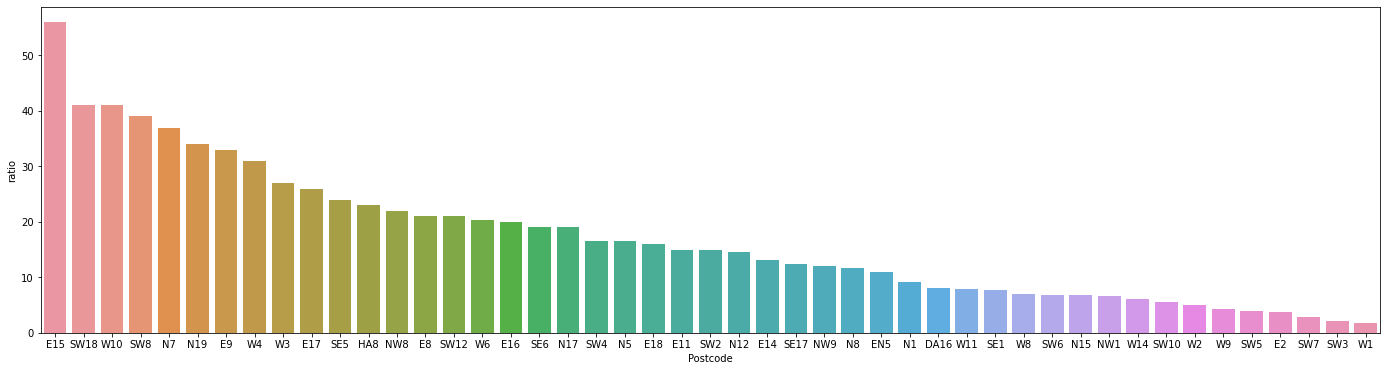

In [70]:
#Postcode & Ratio Visualization as a bar chart
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(24, 6))
ax = sns.barplot(x="Postcode", y="ratio", data=df_venuesclients)

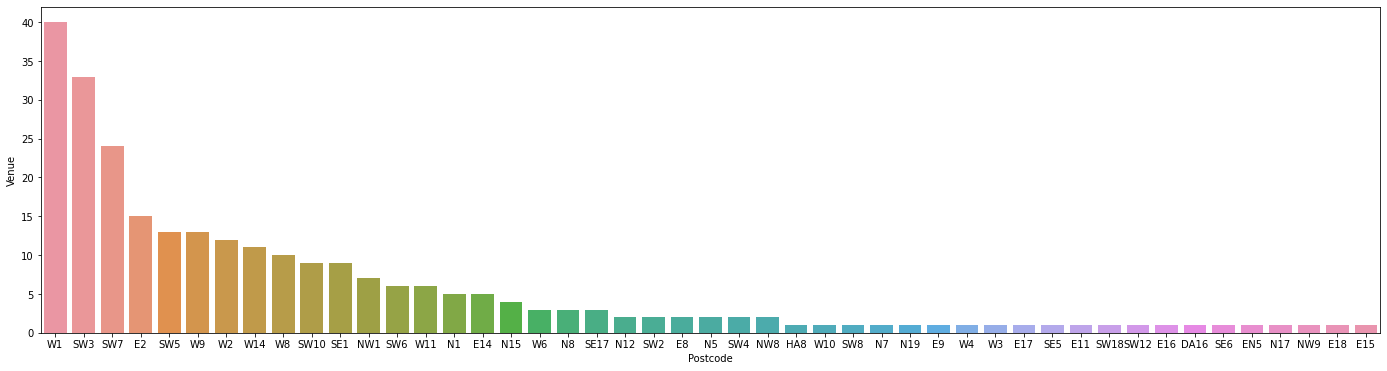

In [71]:
#Postcode & Venues Visualization as a bar chart
plt.figure(figsize=(24, 6))
df_venuesclients.sort_values(['Venue'],ascending=0 ,inplace=True)
ax = sns.barplot(x="Postcode", y="Venue", data=df_venuesclients)

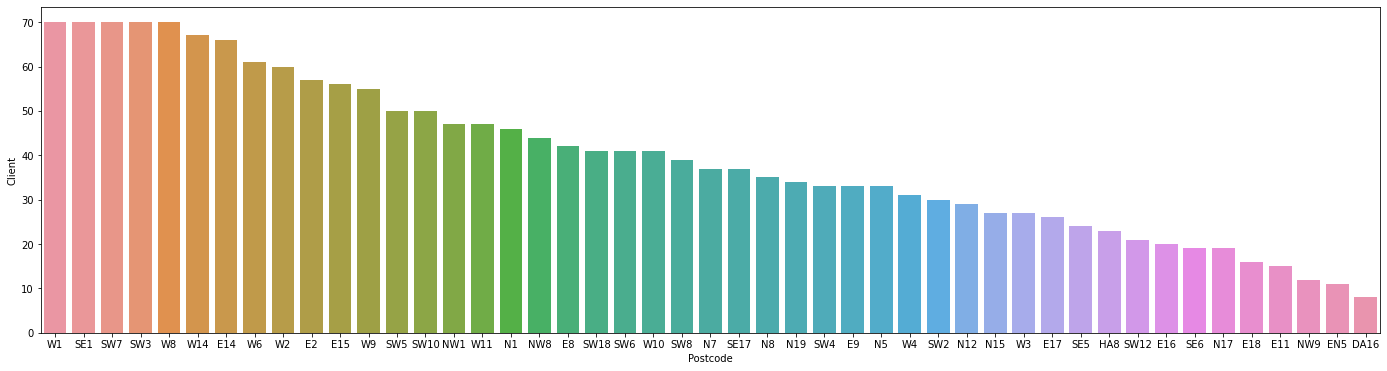

In [72]:
#Postcode & Clients Visualization as a bar chart
plt.figure(figsize=(24, 6))
df_venuesclients.sort_values(['Client'],ascending=0 ,inplace=True)
ax = sns.barplot(x="Postcode", y="Client", data=df_venuesclients)

## As you can see in the map, Walhalm is the top choice. If for some reason (estate values, crime rates etc.) this option doesn't work for the client, he can choose from the other top 5 options that are also visualize on the map.